In [126]:
#Librerías necesarias
import yfinance as yf #para obtener los retornos historicos
import pandas as pd   #para trabajar bases de datos
import cvxpy as cp    # alternativo a gurobi, este es gratis y con pocas variables no hay problemas
import numpy as np
import matplotlib.pyplot as plt

In [115]:
# Primero un ejemplo para ilustrar, recordar y aprender comandos y librerias
# Descarga los datos históricos
#establecer fechas inicio y final
inicio = "2022-01-01"
final  = "2024-11-30"
ticker = "AAPL"  # Reemplaza con el ticker de tu acción
data = yf.download(ticker, start=inicio, end=final)
# Resamplear los datos a fin de mes usando el precio ajustado (Adj Close)
#------------------------------------------------------------------------------------------------------------------------------#
#Precio cierre mensual
monthly_data = data['Close'].resample('M').last() 
# 'Close' es el nombre de la columna, y resample elige el ultimo dato del mes 
#recordar que hay fines de mes feriados o domingos etc,
#------------------------------------------------------------------------------------------------------------------------------#
#Luego para los retornos mensuales
monthly_return=monthly_data.pct_change()

[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\3754788343.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').last()


In [144]:
#Ahora con un vector de tickers, ejemplo en acciones chilenas
tickers = ["SQM", "AGUAS-A.SN", "FALABELLA.SN", "BSAC", "COPEC.SN","CMPC.SN"]
n_tic=len(tickers)
retornos= pd.DataFrame()
inicio = "2002-01-01"
final  = "2024-11-30"
for i in range(n_tic):
    data = yf.download(tickers[i], start=inicio, end=final)
    yearly_data = data['Close'].resample('Y').last() 
    yearly_return=yearly_data.pct_change()
    retornos[tickers[i]]=yearly_return
    
retornos = retornos.dropna()


[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\3830736874.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = data['Close'].resample('Y').last()
[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\3830736874.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = data['Close'].resample('Y').last()
[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\3830736874.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = data['Close'].resample('Y').last()
[*********************100%***********************]  1 of 1 completed
C:\Users\julio\AppData\Local\Temp\ipykernel_10760\3830736874.py:9: Future

In [139]:
retornos.to_excel("retornos.xlsx", sheet_name="Monthly Data")

print("El archivo 'monthly_data.xlsx' se ha guardado correctamente.")

El archivo 'monthly_data.xlsx' se ha guardado correctamente.


In [145]:
r_e=pd.DataFrame()
cov=retornos.cov()
for i in range(n_tic):
    r=retornos[tickers[i]].mean()
    r_e[tickers[i]]=[r]

r_e,cov

(        SQM  AGUAS-A.SN  FALABELLA.SN      BSAC  COPEC.SN   CMPC.SN
 0  0.278093    0.110342       0.14728  0.133624  0.077214  0.101845,
                    SQM  AGUAS-A.SN  FALABELLA.SN      BSAC  COPEC.SN   CMPC.SN
 SQM           0.234884    0.008379      0.045405  0.080399  0.070927  0.073417
 AGUAS-A.SN    0.008379    0.042580      0.027969  0.028188  0.020851  0.036090
 FALABELLA.SN  0.045405    0.027969      0.134941  0.082865  0.074395  0.089742
 BSAC          0.080399    0.028188      0.082865  0.096119  0.059748  0.080446
 COPEC.SN      0.070927    0.020851      0.074395  0.059748  0.079608  0.086981
 CMPC.SN       0.073417    0.036090      0.089742  0.080446  0.086981  0.119158)

### El problema de minimización de Markowitz
### Sea $w_i$ los pesos del activo i (ticker in tickers), tal que $\sum_{i=1}^n w_i = 1$
### La varianza de un portafolio se define matricialmente como $\sigma_p^2 = w^T \Sigma w$, donde  $\Sigma$ es la matriz de covarianza
###
### Finalmente el problema a resolver es el siguiente:
$$
\begin{aligned}
\min_{w} & \quad w^T \Sigma w \\
\text{st:} & \quad \sum_{i=1}^n w_i =1, \\
& \quad \sum_{i=1}^n E[R_i]w_i\geq R^*, \\
& \quad w_i \geq 0.
\end{aligned}
$$


In [141]:
R=r_e.iloc[0].values
w = cp.Variable(n_tic)
R_obj=0.01 # para construir la frontera eficiente se necesita un vector de retornos
f_obj=cp.Minimize(cp.quad_form(w,cov.values))
restricciones=[
    cp.sum(w)==1,
    R @ w >= R_obj,
    w>=0]
problem = cp.Problem(f_obj, restricciones)
problem.solve()

# Resultados
print("Status:", problem.status)  # Debería ser 'optimal'
print("Para R%:", np.round(R_obj*100,4))
print("Pesos óptimos %:", np.round(w.value*100,2))  # Pesos del portafolio
print("Varianza mínima:", problem.value)  # Varianza mínima
print("Volatilidad mínima %:",np.round(np.sqrt(problem.value)*100,2))

Status: optimal
Para R%: 1.0
Pesos óptimos %: [14.79 34.63 13.17 11.22  6.77 19.42]
Varianza mínima: 0.002760483782788892
Volatilidad mínima %: 5.25


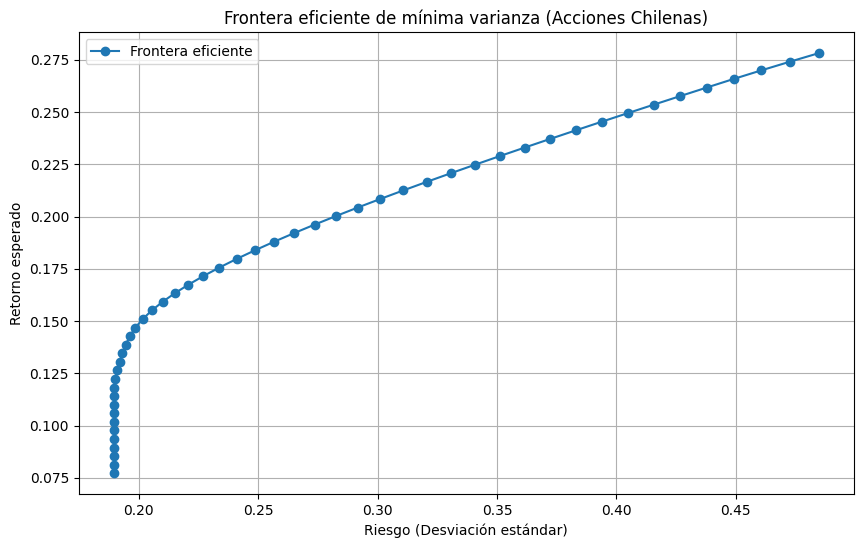

In [146]:
# Problema con varios Retornos para armar la frontera eficiente (RECORDAR QUE ES UNA SOLUCION COMPUTACIONAL)
mu = r_e.iloc[0].values  # Retornos esperados de los activos (promedio)
Sigma = retornos.cov()   # Matriz de covarianza de los retornos
n = len(tickers)
R_min, R_max = mu.min(), mu.max()
R_targets = np.linspace(R_min, R_max, 50)  # 50 valores entre el mínimo y máximo de los retornos
#listas en blanco para guardar resultados
risks = []
returns = []
# Optimización para cada valor de retorno objetivo
for R_target in R_targets:
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma))  # Función objetivo: minimizar la varianza
    constraints = [
        cp.sum(w) == 1,            # La suma de los pesos debe ser igual a 1
        mu @ w >= R_target,        # El retorno del portafolio debe ser mayor o igual a R_target
        w >= 0                     # No hay posiciones cortas (pesos no negativos)
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve()  # Resolver el problema de optimización
    
    # Si el problema es factible, añadir el riesgo (desviación estándar) y el retorno
    if problem.status == 'optimal':
        risks.append(np.sqrt(problem.value))  # Riesgo (desviación estándar)
        returns.append(R_target)
    else:
        risks.append(np.nan)  # Si no es factible, añadir NaN
        returns.append(np.nan)

# Graficar la frontera eficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, marker='o', label="Frontera eficiente")
plt.xlabel("Riesgo (Desviación estándar)")
plt.ylabel("Retorno esperado")
plt.title("Frontera eficiente de mínima varianza (Acciones Chilenas)")
plt.legend()
plt.grid(True)
plt.show()

In [190]:
RF=0.05
Sharpe_ratio=[]
sd_opt=0
retorno_opt=0
max_sr=0
for i in range(len(R_targets)):
    sharpe=(R_targets[i]-RF)/risks[i]
    Sharpe_ratio.append(sharpe)
    if sharpe>=max_sr:
        max_sr=sharpe
        sd_opt=risks[i]
        retorno_opt=R_targets[i]

print(max_sr,sd_opt,retorno_opt)



0.538263305998711 0.24096655847952436 0.17970345640232052


In [195]:
linea_sharpe=[]
rs=np.linspace(0 , 0.5,len(risks))
for i in range(len(rs)):
    punto=RF+max_sr*rs[i]
    linea_sharpe.append(punto)



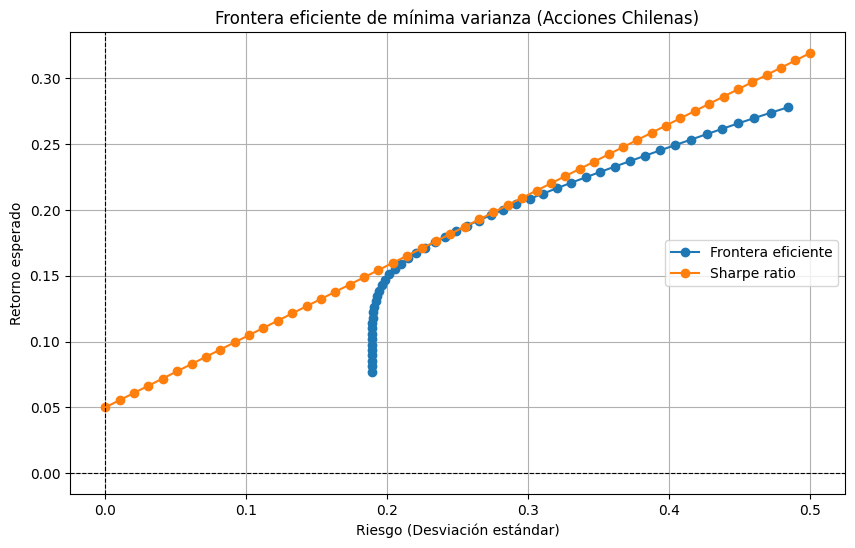

In [196]:
plt.figure(figsize=(10, 6))

# Frontera eficiente
plt.plot(risks, returns, marker='o', label="Frontera eficiente")
plt.plot(rs, linea_sharpe, marker='o', label="Sharpe ratio")

# Etiquetas y título
plt.xlabel("Riesgo (Desviación estándar)")
plt.ylabel("Retorno esperado")
plt.title("Frontera eficiente de mínima varianza (Acciones Chilenas)")

# Agregar líneas de los ejes en (0,0)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Línea horizontal en y=0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Línea vertical en x=0

# Leyenda, cuadrícula y mostrar gráfico
plt.legend()
plt.grid(True)
plt.show()

In [189]:
linea_sharpe

[0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.152062878765266,
 0.15212710425671855,
 0.15237746158409826,
 0.15277844190120918,
 0.15330284488363266,
 0.15394880261281724,
 0.15471406558051282,
 0.15562047956399022,
 0.15688734683487504,
 0.15855525941167187,
 0.16060607578671618,
 0.1630189536246162,
 0.165771257133774,
 0.16883940550478446,
 0.17219961066055692,
 0.17582847695540832,
 0.1797034564023205,
 0.18380316817984732,
 0.1881076002603958,
 0.19259821494980572,
 0.19725798038314118,
 0.2020713480200565,
 0.2070241930825234,
 0.21210373148161327,
 0.21729842357228968,
 0.2225978722978602,
 0.22799272102023882,
 0.23347455456573163,
 0.2390358056889318,
 0.2446696681928094,
 0.25037001726455554,
 0.2561313371260251,
 0.261948655798032,
 0.26781748659436694,
 0.2737337758597184,
 0.2796938564199553,
 0.28569440620464537,
 0.29175273803762697,
 

In [191]:
risks

[0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.18961515233867793,
 0.1897344721784976,
 0.19019959273304696,
 0.19094454471591885,
 0.19191879463520417,
 0.19311887222174157,
 0.19454059827879777,
 0.19622455847704237,
 0.19857817845590053,
 0.20167687115556754,
 0.20548693279675478,
 0.20996964193001638,
 0.21508294517488663,
 0.22078303347148293,
 0.22702571269245977,
 0.2337675177800614,
 0.24096655847952436,
 0.24858311292757485,
 0.256580002242855,
 0.26492278660018337,
 0.2735798237442807,
 0.28252222718005726,
 0.2917237555162258,
 0.3011606581296505,
 0.3108114963584204,
 0.32065695427188107,
 0.33067964885695755,
 0.3408639461783617,
 0.35119578760470904,
 0.36166252840069235,
 0.3722527897248775,
 0.3829563242167556,
 0.3937638948001028,
 0.4046671659889975,
 0.41565860679392885,
 0.42673140424048406,
 0.4378793864971539,
 0